In [1]:
import os
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.feature import hog
from shutil import copy

In [2]:
from dataflow.dataflow import imgaug

In [3]:
path_dataset = '/home/hyunjoon/dataset/cifar-10-images'

In [4]:
list_fn = [l for l in os.listdir(path_dataset) if l.endswith('.jpg')]
list_fn = np.sort(list_fn)

In [8]:
# classwise
perclass_fn = [[] for _ in range(10)]
for fn in list_fn:
    cid = os.path.splitext(fn)[0].split('_')[-1]
    perclass_fn[int(cid)].append(fn)
    
perclass_fn_train = [p[:5000] for p in perclass_fn]
perclass_fn_val = [p[5000:] for p in perclass_fn]
len(perclass_fn_train[0])

# save validation image list
# with open(os.path.join(path_dataset, 'validation.txt'), 'w') as fh:
#     for ii, fn_list in enumerate(perclass_fn_val):
#         fh.write('\n'.join(['{} {}'.format(fn, ii) for fn in fn_list]))
#         fh.write('\n')
with open(os.path.join('train.txt'), 'w') as fh:
    for ii, fn_list in enumerate(perclass_fn_train):
        fh.write('\n'.join(['{} {}'.format(fn, ii) for fn in fn_list]))
        fh.write('\n')

In [24]:
img = cv2.imread(os.path.join(path_dataset, list_fn[0]))

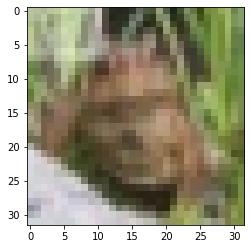

In [25]:
plt.imshow(img)

In [151]:
def create_transforms(img, scale, aspect, trans, num_frames, mean_bgr):
    '''
    scale: (scale_begin, scale_end)
    trans: ((tx0, ty0), (tx1, ty1))
    aspect: (aspect_begin, aspect_end)
    num_frames: number of augmented images to create
    '''
    # interpolation weights
    alphas = np.arange(num_frames) / (num_frames - 1.0)
    
    img_hw = img.shape[:2]

    def _compute_roi(ss, asp, tx, ty, img_hw):
        sx = ss * np.sqrt(asp)
        sy = ss / np.sqrt(asp)
        
        ww = img_hw[1] / sx
        hh = img_hw[0] / sy

        x0 = tx + (img_hw[1] - ww)
        y0 = ty + (img_hw[0] - hh)
        #
        return [x0, y0, x0+ww, y0+hh]
    
    def _create_transform(roi, img_hw, mean_bgr):
        a = (img_hw[1]) / (roi[2] - roi[0])
        b = (img_hw[0]) / (roi[3] - roi[1])
        c = -a * (roi[0] - 0.0)
        d = -b * (roi[1] - 0.0)
        mapping = np.array([[a, 0, c],
                            [0, b, d]]).astype(np.float)
        func = lambda x: cv2.warpAffine(x, mapping,
                                        (img_hw[1], img_hw[0]),
                                        borderMode=cv2.BORDER_REPLICATE) #,
#                                         borderValue=mean_bgr)
        return func, mapping
    
    r_imgs = []
    for ii, a1 in enumerate(alphas):
        a0 = 1.0 - a1
        ss = scale[0] * a0 + scale[1] * a1
        asp = aspect[0] * a0 + aspect[1] * a1
        tx = trans[0][0] * a0 + trans[1][0] * a1
        ty = trans[0][1] * a0 + trans[1][1] * a1

        roi = _compute_roi(ss, asp, tx, ty, img_hw)
        trans_func, mapping = _create_transform(roi, img_hw, mean_bgr)
#         if ii == 0 or ii == len(alphas)-1:
#             print('{}: {}'.format(ii, mapping))
        
        r_imgs.append(trans_func(img))

    return r_imgs

In [152]:
scale_range = (0.8, 1.25)
asp_range = (0.8, 1.25)
trans_range = ((-4, 4), (-4, 4))

In [153]:
def augment_image(img, scale_range, asp_range, trans_range, num_aug=5, num_frame=20):
    '''
    '''
    p_scale = np.random.uniform(scale_range[0], scale_range[1], num_aug)
    p_asp = np.random.uniform(asp_range[0], asp_range[1], num_aug)
    p_tx = np.random.uniform(trans_range[0][0], trans_range[0][1], num_aug)
    p_ty = np.random.uniform(trans_range[1][0], trans_range[1][1], num_aug)
    p_trans = np.stack([p_tx, p_ty], axis=1)
      
    r_imgs = []
    for ii in range(num_aug):
        scale = (p_scale[ii], p_scale[(ii+1) % num_aug])
        asp = (p_asp[ii], p_asp[(ii+1) % num_aug])
        trans = (p_trans[ii], p_trans[(ii+1) % num_aug])
        
        r_imgs.extend(create_transforms(img, scale, asp, trans, num_frame, [127, 127, 127]))
    
    return r_imgs

In [160]:
path_res1 = '/home/hyunjoon/dataset/cifar-10-biased/'
path_res2 = '/home/hyunjoon/dataset/cifar-10-sampled/'
for ii, fn_list in enumerate(perclass_fn_train):
    sampled = np.random.choice(fn_list, 500, replace=False)
    
    if ii == 0:
        for jj, fn in enumerate(sampled):
            img = cv2.imread(os.path.join(path_dataset, fn))
            r_imgs = augment_image(img, scale_range, asp_range, trans_range)
            for kk, r_img in enumerate(r_imgs):
                dst = os.path.join(path_res1, '{:05d}_{:03d}.jpg'.format(jj*100+kk, ii))
                cv2.imwrite(dst, r_img)
    else:
        for jj, fn in enumerate(sampled):
            src = os.path.join(path_dataset, fn)
            dst = os.path.join(path_res1, '{:05d}_{:03d}.jpg'.format(jj, ii))
            copy(src, dst)
            
    for jj, fn in enumerate(sampled):
        src = os.path.join(path_dataset, fn)
        dst = os.path.join(path_res2, '{:05d}_{:03d}.jpg'.format(jj, ii))
        copy(src, dst)

In [164]:
# save image list
list_fn = [l for l in os.listdir(path_res1) if l.endswith('.jpg')]
list_fn = np.sort(list_fn)

with open(os.path.join(path_res1, 'train.txt'), 'w') as fh:
    for fn in list_fn:
        cid = int(os.path.splitext(fn)[0].split('_')[-1])
        fh.write('{} {}\n'.format(fn, cid))

list_fn = [l for l in os.listdir(path_res2) if l.endswith('.jpg')]
list_fn = np.sort(list_fn)
with open(os.path.join(path_res2, 'train.txt'), 'w') as fh:
    for fn in list_fn:
        cid = int(os.path.splitext(fn)[0].split('_')[-1])
        fh.write('{} {}\n'.format(fn, cid))

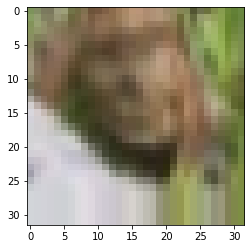

In [137]:
plt.imshow(r_imgs[-1])

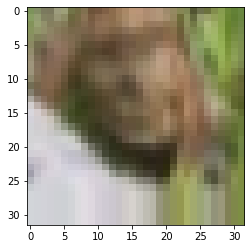

In [138]:
plt.imshow(r_imgs[0])

In [101]:
sims = []
pivot = r_imgs[10]
for r in r_imgs:
    sims.append(ssim(r, pivot, win_size=9, multichannel=True))

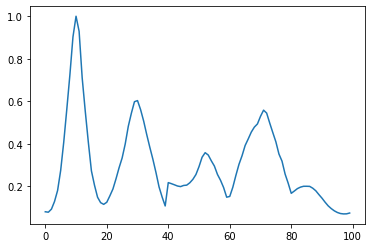

In [102]:
plt.plot(sims)

In [44]:
all_hogs = [hog(r, pixels_per_cell=(2, 2), multichannel=True) for r in r_imgs]

In [52]:
p_hog = all_hogs[9]
sims_hog = [np.sum(p_hog * h) / 194 for h in all_hogs]
sims_hog[0]

0.2821386818459997

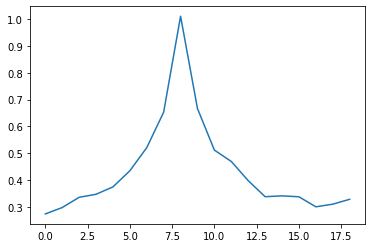

In [53]:
plt.plot(sims_hog[1:])

In [54]:
sims_hog

[0.2821386818459997,
 0.27442577706922877,
 0.29813917372440646,
 0.336203022463631,
 0.34747782776271235,
 0.3750211934472099,
 0.4349462195303519,
 0.5210665131350863,
 0.6530935022324815,
 1.0103092781302474,
 0.6667031957657656,
 0.5119882600787721,
 0.46969159211714634,
 0.3983159243023799,
 0.3385473799667137,
 0.34160550534652656,
 0.33817894469879417,
 0.3008885666834846,
 0.31069073165924843,
 0.32887756339393637]